<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_R/blob/main/Colab_Notebook/02_07_07_01_survival_analysis_cart_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![All-test](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 7.1  Survival Trees


Survival analysis often involves modeling time-to-event data, where the outcome of interest is the time until an event occurs (e.g., death, failure, relapse). Traditional decision tree methods like CART (Classification and Regression Trees) are not directly applicable to survival data due to the presence of censoring and the need to model time-to-event outcomes. To address this, specialized survival tree methods have been developed. This tutorial provides an overview of survival trees, specifically focusing on the CART approach for survival analysis, and demonstrates how to implement it in R.


## Overview


**Survival Trees**, such as **CART for Survival** (Classification and Regression Trees adapted for survival analysis), are a type of decision tree method designed specifically to handle **time-to-event data** with **censoring**—a common scenario in medical, engineering, or social sciences research. Like standard decision trees, survival trees recursively partition the data into subgroups (nodes) based on feature values to maximize homogeneity within each group with respect to the outcome. However, instead of predicting a class label or a continuous value, **each leaf node predicts a survival function**—typically estimated using the **Kaplan–Meier estimator**—based on the individuals in that node.


### Key Characteristics


1. **Handles Censored Data**  
   - In survival analysis, not all subjects experience the event of interest (e.g., death, failure) during the study. These are *right-censored* observations.
   - Survival trees incorporate censored observations appropriately during splitting and estimation, unlike naive adaptations of regression trees.

2. **Splitting Criterion**  
   Survival trees use specialized criteria to decide the best split. Common ones include:
   - **Log-rank test statistic**: Favors splits that maximize the difference in survival distributions between child nodes.
   - **Likelihood-based criteria**: E.g., maximizing the partial likelihood (akin to Cox models).
   - **Discrete-time hazard modeling**: Treats time in intervals and models hazard probabilities.

3. **Prediction Output**  
   - The model predicts a **survival curve** $S(t) = P(T > t)$ for each new observation, based on the Kaplan–Meier curve of the terminal node it falls into.
   - Alternatively, one can summarize the curve into a single value (e.g., median survival time) if needed.

4. **Interpretability**  
   - Like CART, survival trees are highly interpretable: the sequence of splits reveals which covariates are most influential in stratifying risk.



### Advantages


- Non-parametric: No assumptions about baseline hazard or proportional hazards.
- Handles mixed data types and interactions naturally.
- Robust to outliers and missing data (depending on implementation).


### Limitations


- May require larger sample sizes to achieve stable estimates due to data partitioning.
- Prone to overfitting; requires careful tuning (e.g., pruning, cross-validation).
- Less efficient than parametric or semi-parametric models for small datasets.


## Setup R in Python Runtype - Install {rpy2}
{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316573 sha256=7b95a23139a06b58d946caab3c33b327c17f96cb2ef6a7e4bea9719aa8ad3498
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Survival CART from Scratch in R


Fitting a Survival CART model from scratch in R without using any modeling packages (like `rpart`, `survival`, or `party`) is a substantial challenge—but an excellent exercise to understand how survival trees work under the hood.


### Load Data

In [3]:
%%R
# ============================================================
# 1. Load Data
# ============================================================
library(survival)
data(veteran, package = "survival")
df <- veteran[, c("time", "status", "trt", "celltype", "karno", "diagtime", "age", "prior")]

# Encode factors as integers but keep level info
celltype_levels <- levels(as.factor(df$celltype))
df$celltype <- as.integer(as.factor(df$celltype))  # 1=adeno, 2=squamous, 3=large, 4=smallcell
df$trt <- as.integer(df$trt) - 1                   # 0/1
df$prior <- as.integer(df$prior > 0)               # 0/1

# Store meta info for factor handling
factor_vars <- c("celltype")  # only celltype is truly categorical
numeric_vars <- setdiff(names(df), c("time", "status", factor_vars))
head(df)

  time status trt celltype karno diagtime age prior
1   72      1   0        1    60        7  69     0
2  411      1   0        1    70        5  64     1
3  228      1   0        1    60        3  38     0
4  126      1   0        1    60        9  63     1
5  118      1   0        1    70       11  65     1
6   10      1   0        1    20        5  49     0


### Log-Rank Score


Log-rank statistic is commonly used to evaluate the quality of splits in survival trees. It measures the difference in survival between two groups.



In [4]:
%%R
# ============================================================
# 2. Helper: Log-Rank Score
# ============================================================
logrank_score <- function(time, status, group) {
  if (length(unique(group)) < 2) return(-Inf)
  if (sum(group == 0) == 0 || sum(group == 1) == 0) return(-Inf)

  n <- length(time)
  ord <- order(time)
  time <- time[ord]
  status <- status[ord]
  group <- group[ord]

  observed_1 <- 0
  expected_1 <- 0

  i <- 1
  while (i <= n) {
    t <- time[i]
    idx <- which(time == t)
    d <- sum(status[idx])
    y <- length(idx)
    d1 <- sum(status[idx] * group[idx])
    y1 <- sum(group[idx])

    if (y > 1 && d > 0) {
      observed_1 <- observed_1 + d1
      expected_1 <- expected_1 + d * y1 / y
    }
    i <- i + length(idx)
  }
  return(abs(observed_1 - expected_1))
}

### Kaplan–Meier Estimator

In [5]:
%%R
# ============================================================
# 3. Helper: Kaplan–Meier Estimator
# ============================================================
kaplan_meier <- function(time, status) {
  if (length(time) == 0) return(list(time = numeric(0), survival = numeric(0)))

  ord <- order(time)
  time <- time[ord]
  status <- status[ord]

  event_times <- sort(unique(time[status == 1]))
  if (length(event_times) == 0) {
    return(list(time = c(0), survival = c(1)))
  }

  S <- 1
  km_time <- c(0)
  km_surv <- c(1)

  for (t in event_times) {
    d <- sum(status[time == t])
    y <- sum(time >= t)
    if (y > 0) {
      S <- S * (1 - d / y)
      km_time <- c(km_time, t)
      km_surv <- c(km_surv, S)
    }
  }
  return(list(time = km_time, survival = km_surv))
}

### Factor Splits

In [6]:
%%R
# ============================================================
# 4. Generate All Non-Redundant Factor Splits
# ============================================================
generate_factor_splits <- function(x) {
  levels_x <- sort(unique(x))
  k <- length(levels_x)
  if (k <= 1) return(list())

  first_level <- levels_x[1]
  other_levels <- levels_x[-1]

  splits <- list()
  for (r in seq_along(other_levels)) {
    combs <- combn(other_levels, r, simplify = FALSE)
    for (comb in combs) {
      left_levels <- c(first_level, comb)
      group <- as.integer(x %in% left_levels)
      splits <- append(splits, list(list(group = group)))  # list of lists
    }
  }
  return(splits)
}

###  Tree Builder with Factor Support

In [7]:
%%R
# ============================================================
# 5.Tree Builder with Factor Support
# ============================================================
build_survival_tree <- function(data,
                                factor_vars = character(),
                                min_node_size = 10,
                                depth = 0,
                                max_depth = 5) {
  n <- nrow(data)

  # Stopping criteria
  if (n < min_node_size || depth >= max_depth || sum(data$status) == 0) {
    return(list(
      type = "leaf",
      n = n,
      time = data$time,
      status = data$status,
      prediction = kaplan_meier(data$time, data$status)
    ))
  }

  best_score <- -Inf
  best_split <- NULL

  # -------------------------
  # Try numeric variables
  # -------------------------
  numeric_vars <- setdiff(names(data), c("time", "status", factor_vars))
  for (col in numeric_vars) {
    x <- data[[col]]
    if (length(unique(x)) < 2) next

    uniq_vals <- sort(unique(x))
    thresholds <- (uniq_vals[-1] + uniq_vals[-length(uniq_vals)]) / 2

    for (thr in thresholds) {
      group <- as.integer(x > thr)
      n0 <- sum(group == 0); n1 <- sum(group == 1)
      if (n0 < min_node_size || n1 < min_node_size) next

      score <- logrank_score(data$time, data$status, group)
      if (score > best_score) {
        best_score <- score
        best_split <- list(
          type = "numeric",
          variable = col,
          threshold = thr,
          group = group
        )
      }
    }
  }

  # -------------------------
  # Try factor variables
  # -------------------------
  for (col in factor_vars) {
    x <- data[[col]]
    if (length(unique(x)) < 2) next

    splits <- generate_factor_splits(x)
    for (split in splits) {
      group <- split$group
      n0 <- sum(group == 0); n1 <- sum(group == 1)
      if (n0 < min_node_size || n1 < min_node_size) next

      score <- logrank_score(data$time, data$status, group)
      if (score > best_score) {
        best_score <- score
        best_split <- list(
          type = "factor",
          variable = col,
          levels_left = sort(unique(x[group == 1])),
          group = group
        )
      }
    }
  }

  # If no split found
  if (is.null(best_split)) {
    return(list(
      type = "leaf",
      n = n,
      time = data$time,
      status = data$status,
      prediction = kaplan_meier(data$time, data$status)
    ))
  }

  # Recurse
  left_data <- data[best_split$group == 0, , drop = FALSE]
  right_data <- data[best_split$group == 1, , drop = FALSE]

  left_child <- build_survival_tree(left_data, factor_vars, min_node_size, depth + 1, max_depth)
  right_child <- build_survival_tree(right_data, factor_vars, min_node_size, depth + 1, max_depth)

  if (best_split$type == "numeric") {
    return(list(
      type = "internal",
      split_type = "numeric",
      variable = best_split$variable,
      threshold = best_split$threshold,
      left = left_child,
      right = right_child,
      n = n
    ))
  } else {
    return(list(
      type = "internal",
      split_type = "factor",
      variable = best_split$variable,
      levels_left = best_split$levels_left,
      left = left_child,
      right = right_child,
      n = n
    ))
  }
}

### Prediction to Terminal Nodes

In [8]:
%%R
# ============================================================
# 6. Tree Prediction (assign to terminal nodes)
# ============================================================
assign_to_leaf <- function(node, newdata) {
  if (node$type == "leaf") {
    return(node)
  }

  var <- node$variable
  x <- newdata[[var]]

  if (node$split_type == "numeric") {
    if (x <= node$threshold) {
      return(assign_to_leaf(node$left, newdata))
    } else {
      return(assign_to_leaf(node$right, newdata))
    }
  } else { # factor
    if (x %in% node$levels_left) {
      return(assign_to_leaf(node$right, newdata))  # right = left group (group=1)
    } else {
      return(assign_to_leaf(node$left, newdata))
    }
  }
}

# Get leaf for each row
get_leaf_list <- function(tree, data) {
  leaves <- vector("list", nrow(data))
  for (i in 1:nrow(data)) {
    leaves[[i]] <- assign_to_leaf(tree, data[i, , drop = FALSE])
  }
  return(leaves)
}

### Concordance Index (C-index)

In [9]:
%%R
# ============================================================
# 7. Concordance Index (C-index)
# ============================================================
concordance_index <- function(time, status, predicted_risk) {
  # predicted_risk: higher = higher risk (e.g., lower median survival)
  n <- length(time)
  concordant <- 0
  permissible <- 0

  for (i in 1:(n-1)) {
    for (j in (i+1):n) {
      # Only consider pairs where at least one had an event
      if (status[i] == 0 && status[j] == 0) next
      if (time[i] == time[j]) next  # skip ties in time

      # Define which subject died first
      if (time[i] < time[j] && status[i] == 1) {
        # i died before j; i should have higher risk
        permissible <- permissible + 1
        if (predicted_risk[i] > predicted_risk[j]) concordant <- concordant + 1
        if (predicted_risk[i] == predicted_risk[j]) concordant <- concordant + 0.5
      } else if (time[j] < time[i] && status[j] == 1) {
        # j died before i; j should have higher risk
        permissible <- permissible + 1
        if (predicted_risk[j] > predicted_risk[i]) concordant <- concordant + 1
        if (predicted_risk[j] == predicted_risk[i]) concordant <- concordant + 0.5
      }
    }
  }

  if (permissible == 0) return(NA)
  return(concordant / permissible)
}

# Helper: extract median survival from KM
km_median <- function(km_obj) {
  if (length(km_obj$survival) == 0 || max(km_obj$survival) < 0.5) return(Inf)
  if (min(km_obj$survival) >= 0.5) return(max(km_obj$time))
  # Linear interpolation
  idx <- which(km_obj$survival <= 0.5)[1]
  if (idx == 1) return(km_obj$time[1])
  t1 <- km_obj$time[idx - 1]; s1 <- km_obj$survival[idx - 1]
  t2 <- km_obj$time[idx];     s2 <- km_obj$survival[idx]
  med <- t1 + (0.5 - s1) * (t2 - t1) / (s2 - s1)
  return(med)
}

### K-fold Cross-Validation for Pruning

In [10]:
%%R
# ============================================================
# 8. K-fold Cross-Validation for Pruning
# ============================================================
cv_pruning <- function(data, factor_vars, k = 5, min_node_size = 5, max_depth = 5) {
  set.seed(42)
  n <- nrow(data)
  folds <- sample(rep(1:k, length.out = n))

  cp_candidates <- seq(0, max_depth, by = 1)  # depth as proxy for complexity
  cv_errors <- rep(0, length(cp_candidates))

  for (fold in 1:k) {
    cat("CV fold", fold, "\n")
    test_idx <- which(folds == fold)
    train_idx <- which(folds != fold)

    train_data <- data[train_idx, , drop = FALSE]
    test_data <- data[test_idx, , drop = FALSE]

    # Grow deep tree
    full_tree <- build_survival_tree(
      train_data, factor_vars,
      min_node_size = min_node_size,
      max_depth = max_depth
    )

    # Get all possible pruned trees by depth
    for (d in cp_candidates) {
      # For simplicity, we refit trees with max_depth = d
      pruned_tree <- build_survival_tree(
        train_data, factor_vars,
        min_node_size = min_node_size,
        max_depth = d
      )

      # Predict on test set
      test_leaves <- get_leaf_list(pruned_tree, test_data)
      medians <- sapply(test_leaves, function(leaf) km_median(leaf$prediction))
      risk <- 1 / (medians + 1e-6)  # higher risk = lower median

      # Compute C-index (higher = better), so error = 1 - C
      c_idx <- concordance_index(test_data$time, test_data$status, risk)
      if (!is.na(c_idx)) {
        cv_errors[which(cp_candidates == d)] <- cv_errors[which(cp_candidates == d)] + (1 - c_idx)
      }
    }
  }

  cv_errors <- cv_errors / k
  best_depth <- cp_candidates[which.min(cv_errors)]
  cat("Best max_depth:", best_depth, "with CV error:", min(cv_errors, na.rm = TRUE), "\n")

  return(best_depth)
}

### Fit Final Model with CV-Selected Depth

In [11]:
%%R
# ============================================================
# 9. Fit Full Model with CV-Selected Depth
# ============================================================
# Run cross-validation to select depth
best_depth <- cv_pruning(df, factor_vars, k = 3, min_node_size = 5, max_depth = 4)

# Fit final tree
final_tree <- build_survival_tree(
  df, factor_vars,
  min_node_size = 5,
  max_depth = best_depth
)

CV fold 1 
CV fold 2 
CV fold 3 
Best max_depth: 4 with CV error: 0.33113 


### Evaluate C-index

In [12]:
%%R
# ============================================================
# 10. Evaluate C-index
# ============================================================
leaves_all <- get_leaf_list(final_tree, df)
medians_all <- sapply(leaves_all, function(leaf) km_median(leaf$prediction))
risk_score <- 1 / (medians_all + 1e-6)  # avoid Inf

c_index_final <- concordance_index(df$time, df$status, risk_score)
cat("Final C-index:", round(c_index_final, 3), "\n")

Final C-index: 0.675 


### Plot Node-Specific KM Curves

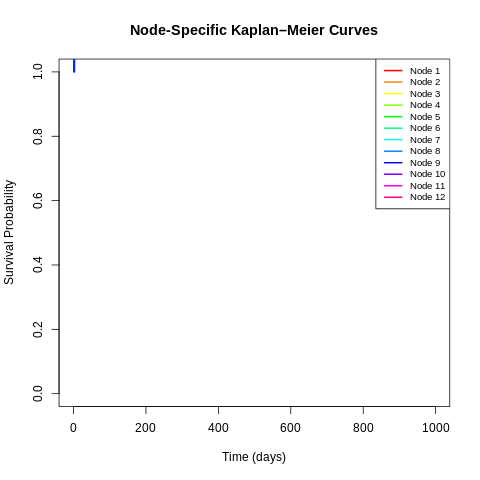

In [13]:
%%R
# ============================================================
# 11. Plot Node-Specific KM Curves
# ============================================================
# Extract unique leaves
leaf_signatures <- sapply(leaves_all, function(leaf) {
  paste(leaf$prediction$time, collapse = ",")
})
unique_leaves <- !duplicated(leaf_signatures)
unique_km_list <- leaves_all[unique_leaves]

# Plot
plot(1, type = "n", xlim = c(0, max(df$time)), ylim = c(0, 1),
     xlab = "Time (days)", ylab = "Survival Probability",
     main = "Node-Specific Kaplan–Meier Curves")

colors <- rainbow(length(unique_km_list))
for (i in seq_along(unique_km_list)) {
  km <- unique_km_list[[i]]
  lines(km$time, km$survival, col = colors[i], lwd = 2)
}

legend("topright", legend = paste("Node", 1:length(unique_km_list)),
       col = colors, lwd = 2, cex = 0.8)

### Tree Structure

In [14]:
%%R

# ============================================================
# 12. Print Tree Structure
# ============================================================
print_tree <- function(node, indent = "") {
  if (node$type == "leaf") {
    med <- km_median(node$prediction)
    cat(indent, "LEAF (n=", node$n, ", median=", round(med, 1), ")\n", sep = "")
  } else if (node$split_type == "numeric") {
    cat(indent, "IF ", node$variable, " <= ", round(node$threshold, 2), " (n=", node$n, ")\n", sep = "")
    cat(indent, "├─", sep = ""); print_tree(node$left, paste0(indent, "│ "))
    cat(indent, "└─", sep = ""); print_tree(node$right, paste0(indent, "  "))
  } else { # factor
    left_levels <- setdiff(sort(unique(df[[node$variable]])), node$levels_left)
    cat(indent, "IF ", node$variable, " in {", paste(left_levels, collapse = ","), "} (n=", node$n, ")\n", sep = "")
    cat(indent, "├─", sep = ""); print_tree(node$left, paste0(indent, "│ "))
    cat(indent, "└─", sep = ""); print_tree(node$right, paste0(indent, "  "))
  }
}

cat("\nFinal Pruned Tree:\n")
print_tree(final_tree)


Final Pruned Tree:
IF celltype in {2,4} (n=137)
├─│ IF trt <= 0.5 (n=75)
│ ├─│ │ IF karno <= 35 (n=45)
│ │ ├─│ │ │ LEAF (n=5, median=17.5)
│ │ └─│ │   IF karno <= 45 (n=40)
│ │   ├─│ │   │ LEAF (n=6, median=12)
│ │   └─│ │     LEAF (n=34, median=120.9)
│ └─│   IF karno <= 35 (n=30)
│   ├─│   │ LEAF (n=9, median=19.5)
│   └─│     IF karno <= 65 (n=21)
│     ├─│     │ LEAF (n=9, median=47.5)
│     └─│       LEAF (n=12, median=99)
└─  IF trt <= 0.5 (n=62)
  ├─  │ IF karno <= 45 (n=24)
  │ ├─  │ │ LEAF (n=7, median=9)
  │ └─  │   IF karno <= 65 (n=17)
  │   ├─  │   │ LEAF (n=6, median=72)
  │   └─  │     LEAF (n=11, median=115.3)
  └─    IF karno <= 45 (n=38)
    ├─    │ LEAF (n=9, median=24.5)
    └─      IF karno <= 55 (n=29)
      ├─      │ LEAF (n=6, median=15)
      └─        LEAF (n=23, median=112)


## Survival CART in R


Survival analysis deals with time-to-event data where the outcome of interest is the time until an event occurs (e.g., death, failure, relapse). Traditional CART (Classification and Regression Trees) cannot handle censored data, but **Survival CART** extends decision trees to accommodate right-censored survival data.


### Install Required R Packages


Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:


In [15]:
%%R
packages <-c(
		 'tidyverse',
		 'survival',
		 'survminer',
		 'ggsurvfit',
		 'tidycmprsk',
		 'rpart',
		 'rpart.plot',
		 'party'
		 )


### Install missing packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')
devtools::install_github("ItziarI/WeDiBaDis", lib='drive/My Drive/R/')


In [ ]:
%%R
install.packages("party", lib='drive/My Drive/R/')


### Verify Installation

In [18]:
%%R
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
 tidyverse   survival  survminer  ggsurvfit tidycmprsk      rpart rpart.plot 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE       TRUE 
     party 
      TRUE 


### Load Packages

In [19]:
%%R
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])



> **Note**: The base `rpart` package supports survival trees using the `"exp"` (exponential) or `"poisson"` method, but for true Kaplan–Meier–based survival trees, we often use the default `method = "exp"` with a `Surv()` object. Alternatively, the `party` package offers conditional inference survival trees (`ctree`). Here, we'll use `rpart`—the most common approach for Survival CART.


### Load and Explore Example Data


We’ll use the built-in `veteran` dataset from the `survival` package, which contains survival data from a lung cancer study.


In [20]:
%%R
data(veteran)
head(veteran)

  trt celltype time status karno diagtime age prior
1   1 squamous   72      1    60        7  69     0
2   1 squamous  411      1    70        5  64    10
3   1 squamous  228      1    60        3  38     0
4   1 squamous  126      1    60        9  63    10
5   1 squamous  118      1    70       11  65    10
6   1 squamous   10      1    20        5  49     0




- `time`: survival time in days
- `status`: 1 = died, 0 = censored
- Other variables: treatment (`trt`), cell type, Karnofsky score (`karno`), etc.

Create a survival object:


In [21]:
%%R
# Create Surv object: time ~ status (1=event, 0=censored)
surv_obj <- with(veteran, Surv(time, status))

### Fit a Survival CART Model


Use `rpart()` with `method = "exp"` (exponential splitting) or simply pass a `Surv` object—the method is auto-detected.


In [22]:
%%R
# Fit Survival CART
tree_model <- rpart(
  Surv(time, status) ~ trt + celltype + karno + diagtime + age + prior,
  data = veteran,
  method = "exp",          # Explicitly specify survival method
  control = rpart.control(
    minsplit = 10,         # Minimum observations to attempt split
    minbucket = 5,         # Minimum obs in terminal node
    cp = 0.01              # Complexity parameter (higher = simpler tree)
  )
)
print(tree_model)

n= 137 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 137 157.564700 1.0000000  
    2) karno>=45 99  80.860270 0.8010216  
      4) celltype=squamous,large 51  36.987910 0.5925485  
        8) age>=40.5 46  25.673310 0.5548008  
         16) age< 64.5 31  18.089880 0.4788033  
           32) diagtime< 3.5 8   2.703323 0.3611369 *
           33) diagtime>=3.5 23  14.187090 0.5486845  
             66) age>=49.5 17   7.669149 0.4796993  
              132) prior>=5 9   3.293874 0.3564800 *
              133) prior< 5 8   1.999435 0.7555039 *
             67) age< 49.5 6   4.884154 0.9041975 *
         17) age>=64.5 15   4.999232 0.8231034 *
        9) age< 40.5 5   8.331211 1.2999540 *
      5) celltype=smallcell,adeno 48  30.803460 1.2590690  
       10) diagtime>=8.5 12   5.716756 0.8615996 *
       11) diagtime< 8.5 36  22.149500 1.4825890  
         22) karno>=65 22   8.229296 1.2122890  
           44) age< 64.5 16   3.895219 1.0448540 *
           45) a


>  **Tip**: The `"exp"` method assumes an exponential survival distribution within nodes and uses a likelihood-based splitting rule. It’s the standard way to fit survival trees in `rpart`.


### Visualize the Tree

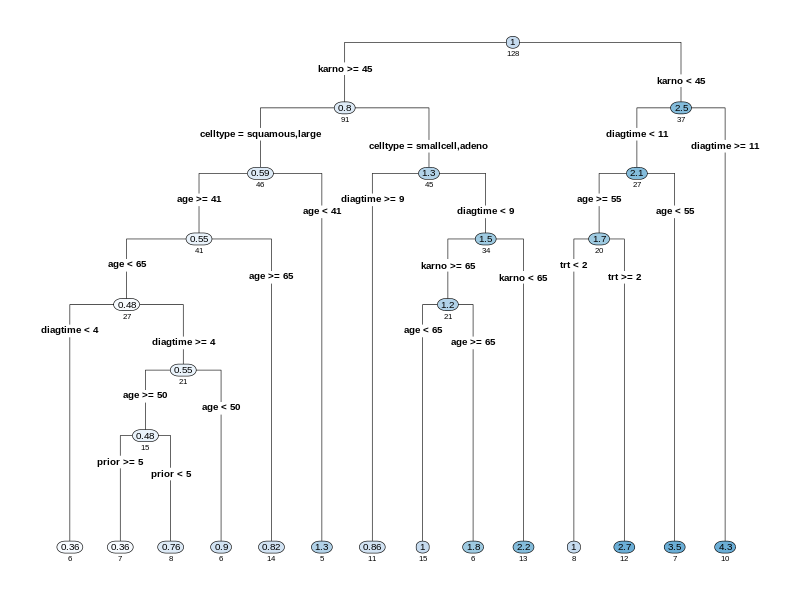

In [27]:
%%R -w 800 -h 600 -u px
# Plot the tree
rpart.plot(tree_model,
           type = 4,
           extra = 2,
           under = TRUE,
           clip.right.labs = FALSE)


Each node shows:

- **Splitting variable and threshold**
- **Number of subjects** (`n=`)
- **Event rate** or **relative death rate**
- **Kaplan–Meier-like survival estimate** (implicit)


### Examine Node-Specific Survival


You can extract predictions and survival estimates per node.


In [25]:
%%R
# Add node ID to data
veteran$node_id <- predict(tree_model)

# View distinct terminal nodes
terminal_nodes <- sort(unique(tree_model$where))
terminal_nodes

 [1]  6  9 10 11 12 13 15 18 19 20 24 25 26 27



Now, plot Kaplan–Meier curves by terminal node:


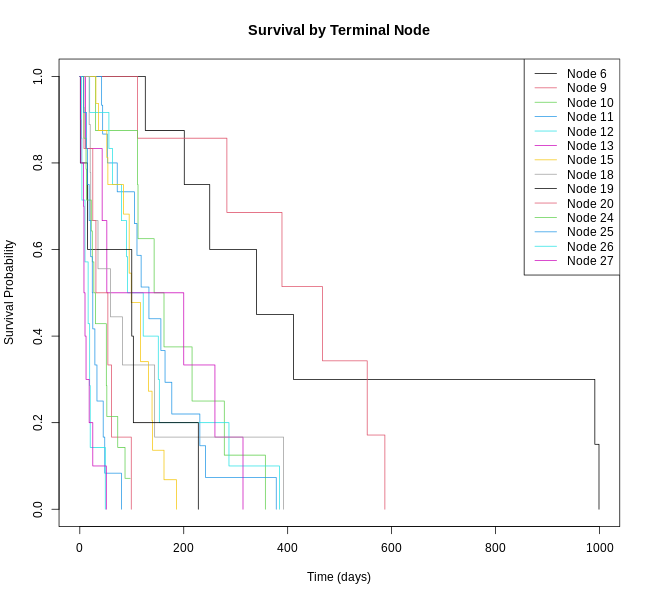

In [28]:
%%R -w 650 -h 600 -u px
# Fit KM curves per node
km_fit <- survfit(Surv(time, status) ~ node_id, data = veteran)

# Plot
plot(km_fit, col = 1:length(terminal_nodes),
     xlab = "Time (days)", ylab = "Survival Probability",
     main = "Survival by Terminal Node")
legend("topright", legend = paste("Node", terminal_nodes),
       col = 1:length(terminal_nodes), lty = 1)


You should see clearly separated survival curves—indicating the tree successfully stratified risk.


###  Model Evaluation

### Cross-validated Error (Using `cptable`)


Survival regression tree:
rpart(formula = Surv(time, status) ~ trt + celltype + karno + 
    diagtime + age + prior, data = veteran, method = "exp", control = rpart.control(minsplit = 10, 
    minbucket = 5, cp = 0.01))

Variables actually used in tree construction:
[1] age      celltype diagtime karno    prior    trt     

Root node error: 157.56/137 = 1.1501

n= 137 

         CP nsplit rel error  xerror    xstd
1  0.192336      0   1.00000 1.01173 0.10318
2  0.082943      1   0.80766 0.87151 0.10876
3  0.038039      2   0.72472 0.77777 0.10741
4  0.031914      3   0.68668 0.82641 0.11283
5  0.019511      5   0.62285 0.87342 0.10840
6  0.018934      7   0.58383 0.94362 0.11574
7  0.016401      8   0.56490 0.94013 0.11561
8  0.011234      9   0.54850 0.94170 0.11761
9  0.011020     10   0.53726 0.91576 0.11098
10 0.010000     13   0.50420 0.92344 0.11217


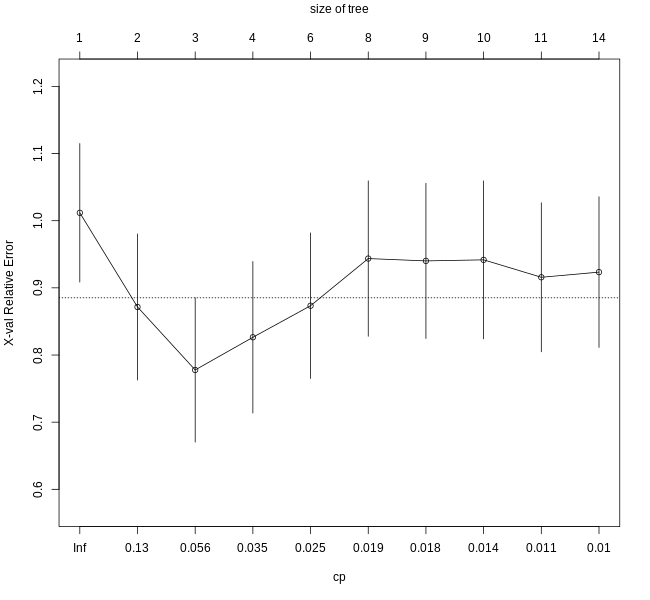

In [30]:
%%R -w 650 -h 600 -u px
# Print cross-validated error vs. complexity parameter
printcp(tree_model)

# Plot CP table to choose optimal cp
plotcp(tree_model)


Choose the `cp` value with the lowest `xerror` (cross-validated relative error). You can prune the tree if needed:


### Pruning the Tree

In [31]:
%%R
# Prune tree
optimal_cp <- tree_model$cptable[which.min(tree_model$cptable[,"xerror"]),"CP"]
pruned_tree <- prune(tree_model, cp = optimal_cp)


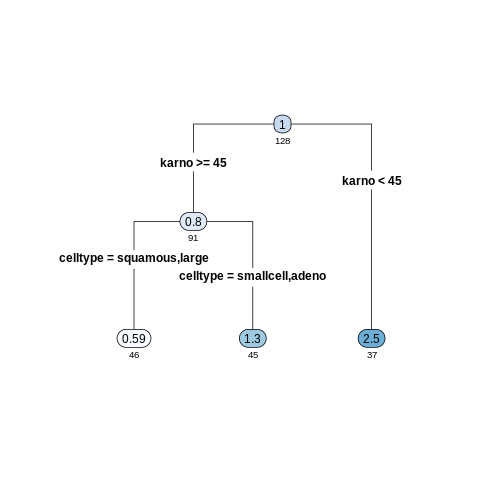

In [32]:
%%R
rpart.plot(pruned_tree ,
           type = 4,
           extra = 2,
           under = TRUE,
           clip.right.labs = FALSE)

###  Concordance Index (C-index)


The C-index measures predictive accuracy (like AUC for survival):


In [33]:
%%R
# Predict median survival time (or linear predictor)
pred <- predict(tree_model, type = "matrix")  # Returns survival matrix
# Extract median survival time per subject
# (Simplified: use -log(0.5) / hazard if exp, but better to use node mean)
# Alternative: use mean survival time in node as proxy
node_means <- aggregate(veteran$time, by = list(node = veteran$node_id), FUN = mean)
names(node_means) <- c("node_id", "mean_time")
veteran_pred <- merge(veteran, node_means, by = "node_id")

In [34]:
%%R
# Compute C-index using survival::concordance
c_index <- concordance(Surv(time, status) ~ mean_time, data = veteran_pred)
print(c_index)

Call:
concordance.formula(object = Surv(time, status) ~ mean_time, 
    data = veteran_pred)

n= 137 
Concordance= 0.7919 se= 0.01933
concordant discordant     tied.x     tied.y    tied.xy 
      6659       1520        625         35          4 



> A C-index > 0.79 indicates reasonable discrimination.




### Make Predictions on New Data

In [ ]:
%%R
# Example new patient
new_patient <- data.frame(
  trt = 1,
  celltype = "squamous",
  karno = 60,
  diagtime = 7,
  age = 69,
  prior = 0
)

# Predict node
pred_node <- predict(tree_model, newdata = new_patient, type = "vector")
cat("New patient assigned to node:", pred_node, "\n")

# To get survival curve: extract KM estimate from that node
# (In practice, you’d store node-level KM curves during training)


>  **Limitation**: `rpart` doesn’t directly output full survival curves for new data. For that, consider `party::ctree` or `randomForestSRC`.


## Conditional Inference Survival Tree (`party` package)


For unbiased variable selection (avoids favoring high-cardinality variables):


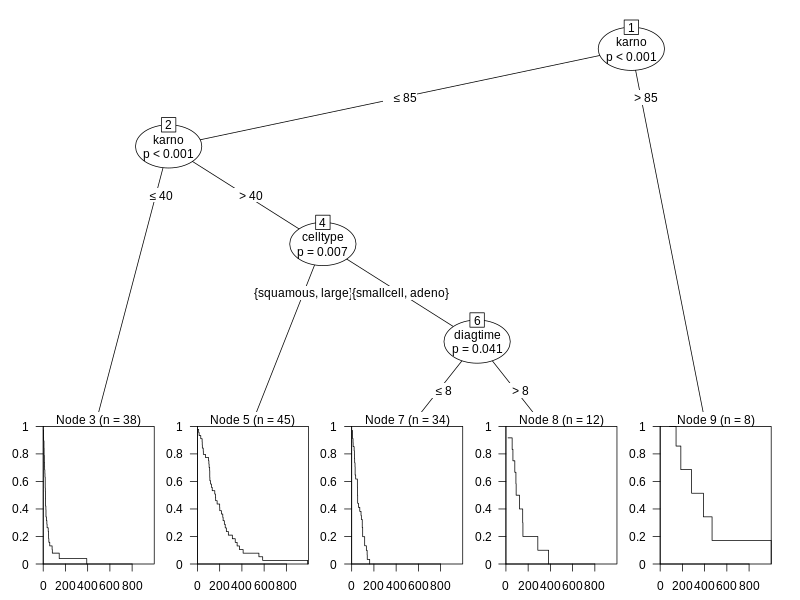

In [37]:
%%R -w 800 -h 600 -u px
ctree_model <- ctree(
  Surv(time, status) ~ trt + celltype + karno + diagtime + age + prior,
  data = veteran
)

plot(ctree_model)

## Summary and Conclusion


Survival CART provides a powerful, interpretable way to model censored time-to-event data using decision trees. By leveraging the `rpart` package in R, you can fit survival trees, visualize them, and evaluate their performance effectively. This approach is particularly useful in medical research for risk stratification and understanding variable importance in survival outcomes. This notebook serves as a starting point for applying Survival CART in your analyses. This is basic step; for more advanced applications, consider exploring ensemble methods like Random Survival Forests or Gradient Boosted Survival Trees.



## Resorces


- Therneau, T. M., & Grambsch, P. M. (2000). *Modeling Survival Data: Extending the Cox Model*. Springer.
- Ishwaran, H., et al. (2008). Random survival forests. *The Annals of Applied Statistics*.
